In [1]:
# %load_ext autoreload
# %autoreload 2
import numpy as np_force
import scipy as sc_force
import autograd.numpy as np
import autograd.scipy as sc
from autograd import grad, elementwise_grad, value_and_grad, grad_and_aux
from matplotlib import pyplot as plt
from skimage.transform import resize as imresize
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import scipy.ndimage as ndim
import autogradLenslets_utils as ag_utils
import scipy.misc as misc
from scipy import signal
from os import listdir
from os.path import isfile, join
import matplotlib.animation as animation
from os import listdir
from os.path import isfile, join
import copy
from bridson import poisson_disc_samples


In [114]:
imnormalize = lambda x:x/np.max(x)    #Normalize image to max of 1

def rgb2imshow(im):
    return imnormalize(np.maximum(np.moveaxis(im,0,-1),0))    #Swaps dimensions, clips negatives and normalizes for display with plt.imshow


# Operate on last 2 dims to match np.fft convention
def pad_func(x, padfrac):
    if np.shape(padfrac) == ():
        if x.ndim is 2:
            padfrac = ((padfrac, padfrac), (padfrac, padfrac))
        elif x.ndim is 3:
            #If x is 3D and pad a single pad value was passed in, assume padding on last 2 dims only
            padfrac = ((0,0), (padfrac, padfrac), (padfrac, padfrac))
        
        
    padr = [];
    for n in range(x.ndim):
        pwpre = np.ceil(padfrac[n][0]*x.shape[n]).astype('int')
        pwpost = np.ceil(padfrac[n][1]*x.shape[n]).astype('int')
        padr.append((pwpre,pwpost))
        #x = zero_pad_ag(x, padr[n], n-2)
    #print("Padr:")
    #print(padr)
    return np.pad(x,padr,'constant')

def crop_func(x,crop_size):
    # Crops the center matching the size in the tuple crop_size. Implicitly deals with higher dimensions?
    cstart = []
    cent = []
    for n in range(x.ndim):
        cstart.append((x.shape[n]-crop_size[n])//2)
    slicer = tuple(slice(cstart[n],cstart[n]+crop_size[n],1) for n in range(len(crop_size)))
    return(x[slicer])


def zero_pad_ag(x, pad_tuple, pad_dim):
    zarg_pre = tuple(pad_tuple[0] if z == pad_dim % x.ndim else x.shape[z] for z in range(x.ndim))
    zpre = np.zeros(zarg_pre)
    zarg_post = tuple(pad_tuple[1] if z == pad_dim % x.ndim else x.shape[z] for z in range(x.ndim))
    zpost = np.zeros(zarg_post)
    out = np.concatenate((zpre, x, zpost), axis=pad_dim)
    
    return out

def propagate_field_freq(lam, z, U, Fx, Fy, padfrac=0):
    k = 2*np.pi/lam

    #siz = np.shape(U)
    #fx = np.linspace(-1/2/ps,1/2/ps,siz[1])
    #fy = np.linspace(-1/2/ps,1/2/ps,siz[0])
    #x = np.linspace(-siz[1]/2*ps,siz[1]/2*ps,siz[1])
    #y = np.linspace(-siz[0]/2*ps,siz[0]/2*ps,siz[0])
    #X,Y = np.meshgrid(x,y)
    #Fx,Fy = np.meshgrid(fx,fy)
    if padfrac != 0:
        shape_orig = np.shape(U)
        U = pad_func(U, padfrac)

        Fx, Fy = np.meshgrid(np.linspace(np.min(Fx), np.max(Fx), U.shape[0]), np.linspace(np.min(Fy), np.max(Fy), U.shape[1]))
        
    Uf = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(U)))
    Hf = np.exp(1j*2*np.pi*z/lam * np.sqrt(1-(lam*Fx)**2 - (lam*Fy)**2))
    Up = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Uf*Hf)))
    if padfrac != 0:
        Up = crop_func(Up, shape_orig)
    return Up

# Project lenslets to aperture. Default is to snap them to the outermost location, but can also delete lenslets that leave the aperture if needed.
def project_to_aperture(x_list, y_list, aperR, mode='snap'):
    
    lr = np.sqrt(x_list**2+y_list**2)
    lout = lr<aperR
    if mode is 'delete':
        x_out = x_list[lout]
        y_out = y_list[lout]
    elif mode is 'snap':
        ya = np.arctan2(y_list, x_list)
        lr = np.minimum(lr, aperR)
        y_out = lr * np.sin(ya)
        x_out = lr * np.cos(ya)
        
    return x_out, y_out


def make_lenslet_surface_ag(Xlist, Ylist, Rlist, xg, yg, offset=10., mean_CA = 0, mode='radius'):
    # Takes in Xlist, Ylist and Rlist: floating point center and radius values for each lenslet
    # xg and yg are grid for the problem
    # Offset: global offset for all lenslets if desired
    # mean_CA: average clear aperture (radius) of each lenslet
    #
    # Outputs: T, the aperture thickness function. 
    
    # If only one radius provided, use same radius for everything
    if np.shape(Rlist) == ():
        Rlist = np.ones_like(Xlist)*Rlist
    if mode is 'curvature':
        Rlist = [1/Rlist[n] if Rlist[n] != 0 else 1/(Rlist[n]+1e-5) for n in range(len(Rlist))]
        
    Nlenslets = Xlist.shape[0]
    T = np.zeros_like(xg)
    for n in range(Nlenslets):

        sph = np.real(np.sqrt(0j+Rlist[n]**2 - (xg-Xlist[n])**2 - (yg-Ylist[n])**2)) - np.sqrt(Rlist[n]**2 - mean_CA**2) + offset
        T = np.maximum(T,sph)
    
    return T-offset

def make_lens_surface_ag(R, xg, yg, mode='radius'):
    if mode is 'curvature':
        if R == 0:
            R = 1/(R+1e-3)
        else:
            R = 1/R
        
    return(np.real(R*np.sqrt(0j+1 - (xg/R)**2 - (yg/R)**2)))

def gen_psf_ag(surface, ior, t, z_obj, obj_def, field, CA, lmbda, xg, yg, Fx, Fy,pupil_phase=0, prop_pad = 0):
    # Inputs:
    # surface: single surface thickness function, units: mm
    # ior : index of refraction of bulk material
    # t : thickness of surface (i.e. distance to output plane)
    # z_obj : distance from object plane. +Inf means object at infinity
    # object_def : 'angle' for angular field definition, 'obj_height' for finite
    # field : tuple (x,y) wavefront field definition. (0,0) is on-axis. Interpreted in context of object_def
    # CA: radius of clear aperture in mm
    # pupil_aberration: additional pupil phase, in radians!
    # lmbda: wavelength in mm
    # xg and yg are the spatial grid (pixel spacing in mm)
    # Fx : frequency grid in 1/mm
    # Fy : same as Fx
    k = np.pi*2/lmbda
    
    if obj_def is 'angle':
        ramp_coeff_x = -np.tan(field[0]*np.pi/180)
        ramp_coeff_y = -np.tan(field[1]*np.pi/180)
        ramp = xg*ramp_coeff_x + yg*ramp_coeff_y
        if z_obj is 'inf':
            U_in = np.exp(1j*k*(ramp))
        else:
            #U_in = np.exp(1j*k*(z_obj*np.sqrt(1-(xg/z_obj)**2 - (yg/z_obj)**2) + ramp))
            U_in = np.exp(1j*k*(z_obj - z_obj*np.sqrt(1+(yg/z_obj)**2+(xg/z_obj)**2) + ramp))
    elif obj_def is 'obj_height':
        if z_obj is 'inf':
            raise Exception('cannot use obj_height and object at infinity')
        else:
            U_in = np.exp(1j*-z_obj*k*np.sqrt(1-((xg-field[0])/z_obj)**2 - ((yg-field[1])/z_obj)**2))
    
    U_out = U_in * np.exp(1j*(k*(ior-1)*surface + pupil_phase))
    amp = np.sqrt(xg**2 + yg**2) <= CA
    U_prop = propagate_field_freq(lmbda, t, amp*U_out, Fx, Fy, padfrac = 0)
    
    psf = np.abs(U_prop)**2
    return(psf/np.sum(psf))
    

In [126]:
# Setup constants

samples = (768,768)   #Grid for PSF simulation

# min and max lenslet focal lengths
fmin = 6
fmax = 20
ior = 1.56

# Min and max lenslet radii
Rmin = fmin*(ior-1)
Rmax = fmax*(ior-1)

# Convert to curvatures
cmin = 1/Rmax
cmax = 1/Rmin

# Number of lenslets to start with. These will be either clipped by or snapped to an aperture function!
#Nlenslets = 35

xrng = (-1.8,1.8)    #Range, in mm, of grid
yrng = (-1.8,1.8)

t = 10    #Distance to sensor from mask

#Compute depth range of virtual image that mask sees (this is assuming an objective is doing some magnification)

zmin_virtual = 1/(1/t - 1/fmin)
zmax_virtual = 1/(1/t - 1/fmax)
CA = .9;
mean_lenslet_CA = .2




8


Text(0.5,1,'Number of lenslets: 32')

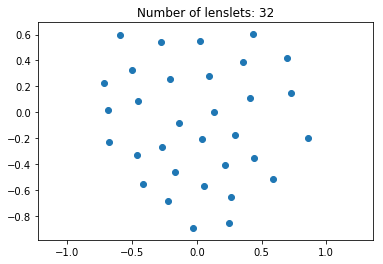

In [225]:
ca = .9   #clear aperture radius in mm

# x1 = np.random.rand(Nlenslets)*2-1   # Initialize locations
# y1 = np.random.rand(Nlenslets)*2-1

l = poisson_disc_samples(width=2*CA, height=2*CA, r=1*mean_lenslet_CA)
x1 = np.array([l[n][0] for n in range(np.shape(l)[0])]) - CA
y1 = np.array([l[n][1] for n in range(np.shape(l)[0])]) - CA

x1, y1 = project_to_aperture(x1, y1, CA,mode='delete')   #
Nlenslets = np.max(np.shape(x1))

Nz = np.ceil(np.sqrt(Nlenslets*2)).astype('int')
print(Nz)

#R = np.random.rand(Nlenslets)*(Rmax - Rmin) + Rmin
R = np_force.random.permutation(1/(np.linspace(1/Rmax, 1/Rmin, Nlenslets)))

xg = np.linspace(xrng[0], xrng[1], samples[0])
yg = np.linspace(yrng[0], yrng[1], samples[1])
xg, yg = np_force.meshgrid(xg,yg)

aperR = np.sqrt(xg**2 + yg**2)<ca
plt.figure()
plt.scatter(x1,y1)

plt.axis('equal')
plt.title('Number of lenslets: {}'.format(Nlenslets))

In [226]:
defocus_list = 1/(np.linspace(1/zmin_virtual, 1/zmax_virtual, Nz))
print(defocus_list)

[-1.5000000e+01 -2.0000000e+01 -3.0000000e+01 -6.0000000e+01
  7.2057594e+16  6.0000000e+01  3.0000000e+01  2.0000000e+01]


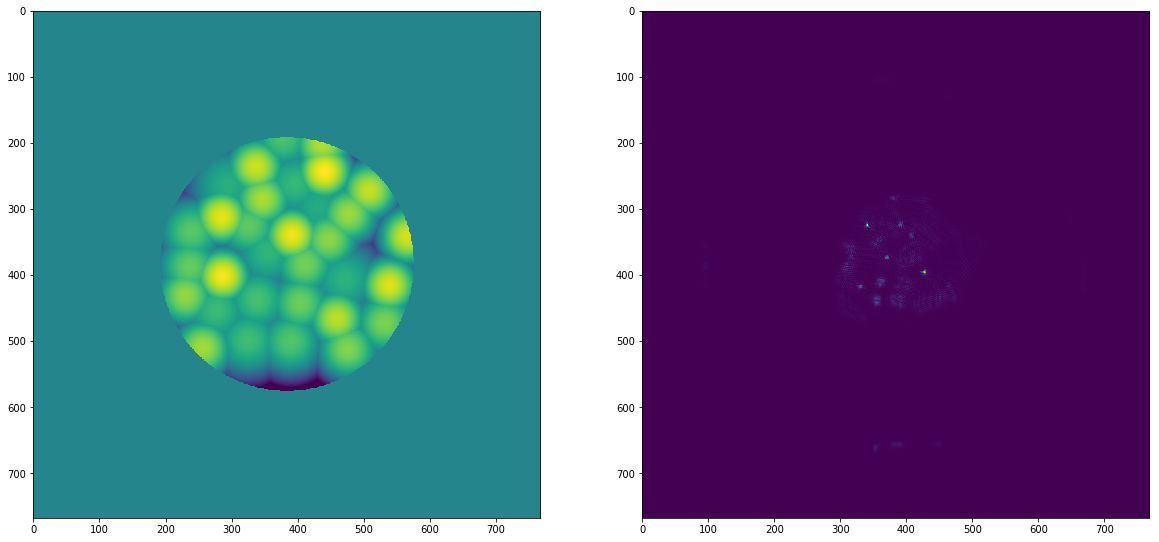

In [227]:
ps = (xrng[1] - xrng[0])/samples[0]

lens_curv = 1/R

x_list = x1;
y_list = y1;
#ltest = make_lens_surface_ag(lens_rad, xg, yg)
print(np.shape(x_list))
ltest = make_lenslet_surface_ag(x_list, y_list, lens_curv, xg, yg,offset=.005, mean_CA = mean_lenslet_CA, mode='curvature')
fx = np.linspace(-1/2/ps,1/2/ps,ltest.shape[1])
fy = np.linspace(-1/2/ps,1/2/ps, ltest.shape[0])
Fx,Fy = np.meshgrid(fx,fy)

#ltest = make_lenslet_surface_ag(Xlist, Ylist, Rlist, xg, yg, offset):


fig = plt.figure(figsize=(20,10));




f,ax = plt.subplots(1,2,figsize=(20,10))

ax[0].imshow(ltest*aperR)

field_list = np.linspace(0,0,1)
zstack = []
for defocus in defocus_list:
    for field in field_list:
        fld = tuple([2*field,0])
        zstack.append(gen_psf_ag(ltest, ior, t, defocus, 'angle',fld,.9,510e-6, xg, yg, Fx, Fy, 0, prop_pad = .5))

        ax[1].imshow(zstack[-1])
        display.display(f)
        display.clear_output(wait=True)


In [228]:
print(range(Nz))

range(0, 8)


[[ 5.2669701   4.93953733  5.03230256  5.24178779  5.47871456  6.01316854
   5.87283934  5.46075368]
 [ 4.93953733  7.57762105  5.89240596  6.1604465   6.29021802  6.99510959
   6.71468385  6.04219679]
 [ 5.03230256  5.89240596  8.17714876  6.78751136  7.0563832   7.7607842
   7.62624723  7.03007591]
 [ 5.24178779  6.1604465   6.78751136  9.41779591  8.1775695   8.99638681
   9.06221299  8.48885838]
 [ 5.47871456  6.29021802  7.0563832   8.1775695  10.95506992 10.50781808
  11.00950585 10.50439924]
 [ 6.01316854  6.99510959  7.7607842   8.99638681 10.50781808 14.98623632
  13.87915092 13.46473286]
 [ 5.87283934  6.71468385  7.62624723  9.06221299 11.00950585 13.87915092
  17.68102856 17.39839266]
 [ 5.46075368  6.04219679  7.03007591  8.48885838 10.50439924 13.46473286
  17.39839266 20.51957508]]


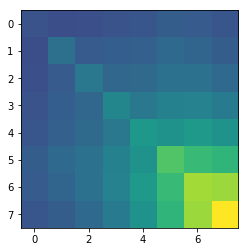

In [250]:
psf_spect = np.fft.fft2(zstack,norm='ortho')
Rmat = np.zeros((Nz,Nz))
for z1 in range(Nz):
    for z2 in np.r_[z1:Nz]:
      
        Fcorr = np.conj(psf_spect[z1])*psf_spect[z2]
        Rmat[z1,z2] = np.sum(np.abs(Fcorr)**2)
        
Rmat = np.transpose(Rmat)*(Rmat==0) + Rmat
plt.imshow?
plt.imshow(Rmat,vmin=0)
print(Rmat*1e12)

# test12 = np.sum(np.abs(np.conj(psf_spect[z1])*psf_spect[z2])**2)
# cor = np.real(np.fft.ifft2(np.conj(psf_spect[z1])*psf_spect[z2],norm='ortho'))
# test12_real = np.sum(cor**2)
# print(test12)
# print(test12_real)

# plt.imshow(np.fft.ifftshift(cor))

In [ ]:
def grad_lenslets(xlist, ylist, Rlist):
    